<a href="https://colab.research.google.com/github/JonatanGrassi/HelperCapacity/blob/main/HPC/Cuaderno_2_martes_grupo1_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1 Introduccion**

Este ejercicio desde el punto de vista de HPC viene a mostrar como el poder del paralelismo permite poder tratar algorirmos de alta complejidad, En el desarrollo de este cuaderno mostraremos como se puede entrenar un modelo de redes neuronales con buena aproximacion en un tiempo aceptable(minutos) cosa que si estariamos implementando este desarrollo en arquitecturas no configurables y por tanto secuenciales los tiempos,por ejemplo para el aprendizaje del modelo, serian inviables.La GPU nos viene a solucionar esa necesidad de paralelismo permitiendonos ejecutar miles de thread que pueden procesar una imagen simultaneamente para extraerles caracteristicas significativas


---
#**2 Armado del ambiente**

### 2.1. Instalación librerias kera y tensorflow



In [1]:
# Instalación de librerías 
!pip install keras
!pip install tensorflow

### 2.2 Dataset:

Obtenemos el Dataset y lo descomprimimos quedara alojado en la seccion archivos de este entorno

In [2]:
!pip install gdown
!gdown --id 1rNKWWrb30WQkmsmuLQPxdw66F1VQU7Dk
!unrar x -Y "/content/images.rar" "/content/"
# Definimos las rutas del dataset 
train_data_dir = '/content/images/train'
val_data_dir = '/content/images/validation'

Se han truncado las últimas 5000 líneas del flujo de salida.
Extracting  /content/images/validation/angry/5519.jpg                     82%  OK 
Extracting  /content/images/validation/angry/5564.jpg                     82%  OK 
Extracting  /content/images/validation/angry/5570.jpg                     82%  OK 
Extracting  /content/images/validation/angry/5582.jpg                     82%  OK 
Extracting  /content/images/validation/angry/5607.jpg                     82%  OK 
Extracting  /content/images/validation/angry/5610.jpg                     82%  OK 
Extracting  /content/images/validation/angry/5637.jpg                     82%  OK 
Extracting  /content/images/validation/angry/5732.jpg                     82%  OK 
Extracting  /content/images/validation/angry/5739.jpg                     82%  OK 
Extracting  /content/images/validation/angry/5780.jpg                     82%  OK 
Extracting  /conten

### 2.3 Configuración dataset:

Definimos algunos parámetro importantes como: tamaño de imagenes, número de clases, etiquetas de las clases, número de epocas, batch size. Finalmente configuramos el dataset

In [3]:
#@title Ingresar cantidad de ciclos de aprendizaje
#@markdown Ingrese los ciclos de aprendizaje(advertencia puede demorar demasiado(horas) si introduce un numero demasiado grande) es aconcejable dejarlo en 10


epochs =   10#@param {type: "number"}




In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Definimos algunos parámetros importantes
width_shape = 48
height_shape = 48
num_classes = 5
batch_size = 32
class_names = ['angry','fear','happy','neutral','surprise']

# Configuramos el dataset de entrenamiento y validación
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

try:
  train_generator = train_datagen.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',shuffle=True)

  val_generator = val_datagen.flow_from_directory(  
    val_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',shuffle=True)
except:
   print('\033[91m' + "**Error**:" + '\033[0m' + "\nEs necesario ejecutar el paso2.2 (Dataset)")



Found 23447 images belonging to 5 classes.
Found 5816 images belonging to 5 classes.


---
#**3 Desarrollo**



### 3.1 Definimos la arquitectura del modelo CNN
En esta seccion definiremos las distintas capas de nuestra red neuronal , en este caso son del tipo convolucional(estas aprenden  a reconocer una diversidad de objetos dentro de imágenes) por tanto luego debemos entrenarlas, en simples palabras este tipo de arquitectura nos permitira ir filtrando los aspectos mas importantes de cada imagen y obteniendo caracteristicas distintivas 

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, AveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam

model = Sequential()

## Extracción de Características
model.add(Conv2D(32,(3,3),padding = 'same',input_shape = (width_shape,height_shape,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout (0.2))

model.add(Conv2D(128,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout (0.2))

model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

## Clasificación
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

# Revisamos el modelo CNN
model.summary()
try:
  # Compilamos y estamos listos para el entrenamiento
  opt = Adam(learning_rate=1e-4, decay=1e-4 / epochs)
  model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
except:
   print('\033[91m' + "**Error**:" + '\033[0m' + "\nCompruebe si definio los ciclos(2.3 Configuración dataset:Configurar cantidad de ciclos de aprendizaje)")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        5

### 3.2 Entrenamiento:
Aqui teniendo en cuenta la cantidad de pasos/ciclos en la configuracion del dataset comenzaremos a entrenar la red neuronal, con cada imagen procesada ira obteniendo caracteristicas especificas de cada una y podra clasificarlas.A mayor cantidad de imagenes le entreguemos y ciclos ejecute mejores resultados tendremos. En nuestro caso esa clasificacion sera :

*   Happy / Feliz
*   Angry / Enojado
*   Surprise / Sorprendido
*   Fear / Atemorizado
*   Neutral / Sin expresion

**Asegurece de estar en un entorno GPU ya que reducira los tiempos de aprendizaje significativamente**

In [6]:

model.fit(  
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_steps=val_generator.n//batch_size)


Epoch 1/10
732/732 [==============================] - 34s 31ms/step - loss: 1.7214 - accuracy: 0.2750 - val_loss: 1.5771 - val_accuracy: 0.3196
Epoch 2/10
732/732 [==============================] - 21s 29ms/step - loss: 1.6080 - accuracy: 0.3085 - val_loss: 1.4935 - val_accuracy: 0.3550
Epoch 3/10
732/732 [==============================] - 21s 29ms/step - loss: 1.5097 - accuracy: 0.3598 - val_loss: 1.3703 - val_accuracy: 0.4449
Epoch 4/10
732/732 [==============================] - 21s 29ms/step - loss: 1.4084 - accuracy: 0.4160 - val_loss: 1.3591 - val_accuracy: 0.4518
Epoch 5/10
732/732 [==============================] - 20s 28ms/step - loss: 1.3413 - accuracy: 0.4508 - val_loss: 1.2931 - val_accuracy: 0.4765
Epoch 6/10
732/732 [==============================] - 21s 28ms/step - loss: 1.2837 - accuracy: 0.4762 - val_loss: 1.1610 - val_accuracy: 0.5307
Epoch 7/10
732/732 [==============================] - 20s 28ms/step - loss: 1.2420 - accuracy: 0.4957 - val_loss: 1.1614 - val_accuracy:

### 3.3 Prueba del modelo:
Por ultimo realizamos pruebas con imagenes para corroborar que tanto aprendio nuestro modelo y si es que puede lograr indentificar personas felices, atemorizadas, enojadas, sorprendidas o sin expresion.

In [7]:
#@markdown **Cargar una imagen**

#@markdown Aqui podra ir seleccionando las imagenes para probar el modelo.
#@markdown Las carpetas contenidas en el directorio "/content/images/validation "( que se puede visualizar en la seccion archivos de este entorno) condicen con las expresiones ( happy,angry,fear,neutral,surprise ) podra cambiar la carpeta y la imagen que quiere probar.

#@markdown Ejemplo: /content/images/validation/(angry | fear | happy | neutral | surprise )/[Nombre imagen].jpg


ruta_imagen = "/content/images/validation/angry/10052.jpg"  #@param {type: "string"}
#@markdown

**Probamos el modelo**

angry


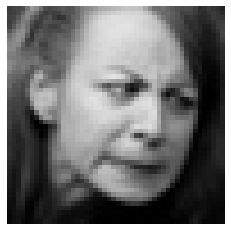

In [8]:
from tensorflow.keras.models import load_model
import cv2

from PIL import Image 
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

faces = []

# Cargamos una imagen del directorio
imaget_path = ruta_imagen

image=cv2.imread(imaget_path)

# Redimensionamos la imagen y convertimos a gray
try:
  face = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
except:
  print ('\033[91m' + "**Error**:" + '\033[0m' + "\n Asegurece que la ruta de la imagen existe")
face = cv2.resize(face, (48,48))
face2 = img_to_array(face)
face2 = np.expand_dims(face2,axis=0)

faces.append(face2)

# El modelo estima la predicción
preds = model.predict(faces)

print(class_names[np.argmax(preds)])
plt.imshow(image)
plt.axis('off')
plt.show()

---
#**4 Métricas del modelo**
Se muestra en pantalla la matriz de confusion que nos dara informacion para comprender que tanto aprendio nuestro modelo y que preciso es a la hora de identificar las expresiones(happy,angry,fear,neutral,surprise)

Found 5816 images belonging to 5 classes.
              precision    recall  f1-score   support

       angry       0.57      0.29      0.38       960
        fear       0.41      0.23      0.30      1018
       happy       0.69      0.83      0.76      1825
     neutral       0.46      0.73      0.56      1216
    surprise       0.72      0.56      0.63       797

    accuracy                           0.58      5816
   macro avg       0.57      0.53      0.53      5816
weighted avg       0.58      0.58      0.56      5816



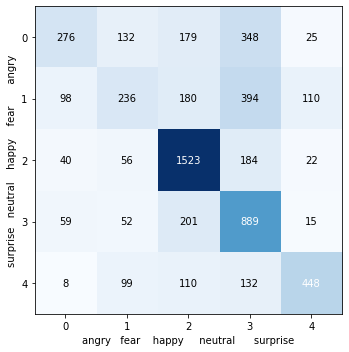

In [10]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.models import load_model
import numpy as np

# Configuración del dataset de validación sin shuffle
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow_from_directory(  
    val_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',shuffle=False)

predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_real = val_generator.classes

matc=confusion_matrix(y_real, y_pred)
plot_confusion_matrix(conf_mat=matc, figsize=(5,5),show_normed=False)
plt.ylabel("surprise   neutral    happy    fear       angry")
plt.xlabel("angry   fear    happy     neutral      surprise")
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, target_names= ['angry','fear','happy','neutral','surprise']))

##4.1 **Entendiendo la matriz de confusion**

* Precision: Porcentaje que indica la presicion con la que que nuestro modelo detecta una determinada expresion correctamente.
* Recall: Es la proporción de casos positivos que fueron correctamente identificadas por el modelo.
* f1 - Score: se utiliza para combinar las medidas de precision y recall en un sólo valor. Se utiliza para comparar con otros algoritmos
* Support: Cantidad de imagenes referidas a una expresion facial que se utilizo para corroborar las predicciones del modelo.
* accurary: Es el porcentaje de predicciones que se hicieron correctamente en todas las clases
* macro avg y weighted: Utilizado para visualizar si nuestras clases estan desequilibradas 

#### Matriz 
**Estos valores pueden variar, la forma de interpretarla sera igual**

Si analizamos la entrada 'angry' de la matriz vemos que:

* Se hacen detectado 276 imagenes con expresion angry correctamente 
* 132 casos se ha confundido con la expresion fear
* 179 casos se ha confundido con la expresion happy
* 348 veces se ha confundido con la expresion neutral
* 25 casos se ha confundido con la expresion surprise

Vemos que como lo indica arriba de la matriz la presicion es de un 57% por lo tanto da a entender que necesita mas ciclos de aprendizaje para mejorar dicha presicion y si el dataset contiene mas imagenes sera mejor aun.

---
#**5 Conclusiones**

Sin duda la necesidad de paralelismo llevo a que la arquitectura de las cpu comience a mutar en busca de dar solucion a los poblemas referidos al procesamiento de grandes volumenes de datos y algoritmos muy complejos, Con la llegada de las arquitecturas configurables se fue mejorando los tiempos de respuesta y apartir de paradigmas como divide y venceras se redujo esa complejidad mencionada y llevo a poder hacer cosas inimaginables. Lo desarrollado en este cuaderno es un trozo que trata de demostrar como se aprovecho ese avance utilizando la GPU como princpial actor durante etapas como la extraccion de caracteristas en algoritmos de deeplerning como este

#**6 Bibliografia**

[1] David Revelo Luna,<< Face emotion >>,16 jul 2021,[En Linea] https://github.com/DavidReveloLuna/Face_Emotion/blob/master/FaceEmotion.ipynb

[2] Juan Barrios ,<< Redes Neuronales Convolucionales >>,[En linea] https://www.juanbarrios.com/redes-neurales-convolucionales/

[3] Jonathan Oheix, << Face expression recognition dataset >>, [En linea] https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

[4] Oscar Frausto-Pérez , Alfonso Rojas-Domínguez,Manuel Ornelas-Rodríguez, Héctor Puga, Martín Carpio, << Entrenamiento dinámico de redes convolucionales profundas para clasificación de imágenes >> [En Linea] https://www.academia.edu/54623038/Entrenamiento_din%C3%A1mico_de_redes_convolucionales_profundas_para_clasificaci%C3%B3n_de_im%C3%A1genes

[5] Ligdi Gonzalez, << Matriz de confusion >>, 17 may 2019 [En Linea] https://aprendeia.com/matriz-de-confusion-machine-learning/

[6] Ramírez Q. Juan A. y Chacón M. Mario I , << Redes neuronales artificiales para el procesamientode imágenes, una revisión de la última década >> 1 july 2011, [En linea] https://www.academia.edu/30091544/Redes_neuronales_artificiales_para_el_procesamiento_de_im%C3%A1genes_una_revisi%C3%B3n_de_la_%C3%BAltima_d%C3%A9cada_Artificial_neural_networks_for_image_processing_a_review_of_the_last_decade

[7] J. Aguilar, E. Leiss , << Introducción a la Computación Paralela >> 2004 , [En Linea] http://so-unlam.com.ar/material-clase/HPC/Introducci%C3%B3n%20a%20la%20Computaci%C3%B3n%20Paralela.pdf

[8] Palomo Recuero de los Santos, << Machine Learning a tu alcance: La matriz de confusión >> ,23 jan 2018, [En linea] https://empresas.blogthinkbig.com/ml-a-tu-alcance-matriz-confusion/